# Compulsory Assignment 1: Dense neural networks - Implementing an ANN with Keras

Please fill out the the group name, number, members and optionally the group name below.

**Group number 1**: Ole Andreas Grøtting\
**Group member 2**: Jørgen Svendsli\
**Group member 3**: Daniel Yang Tsan\
**Group name (optional)**: Gruppe 14

# Assignment submission

To complete this assignment, answer the all the questions in this notebook and write the code required to implement different models. **Submit the assignment by handing in this notebook as both an .ipynb file and a .pdf file**.

Here are some do’s and don’ts for the submission:

- Read questions thoroughly before answering.
- Make sure to answer all questions.
- Ensure all code cells are run.
- Label all axes in plots.
- Ensure all figures are visible in the PDF.
- Provide a brief explanation of how your code works

# Introduction

In this assignment we will work with the task of classifying hand gestures from the Sign Language MNIST dataset. This time you will implement the network using the Keras API of the TensorFlow library. TensorFlow and PyTorch are both free open-source software libraries intended to simplify multiplication of tensors, but are mostly used for the design and implementation of deep neural networks. Both libraries simplify the implementation of neural networks, and allow for faster training of networks by utlizing hardware acceleration with Graphical Processing Units (GPUs) or Tensor Processing Units (TPUs)

TensorFlow was developed by Google Brain for internal use in Google and was initially released under Apache 2.0 License in 2015 [1](https://en.wikipedia.org/wiki/TensorFlow). Keras was initially released as separate software library, developed by François Chollet, to simplify the Python interface for design of artificial neural networks. Up until version 2.3 Keras supported multiple backend libraries including TensorFlow, Microsoft Cognitive Toolkit, Theano, and PlaidML [2](https://en.wikipedia.org/wiki/Keras). When TensorFlow 2.0 was released in 2019, keras was included as a TensorFlow specific API that is accessible by:

```python
import tensorflow.keras as ks
```
PyTorch was originally developed by Meta AI (formerly known as Facebook) in 2016, but is now under umbrella of the Linux foundation, and is open-source under the BSD license [3](https://en.wikipedia.org/wiki/PyTorch). While TensorFlow was the most popular framework for a long time, PyTorch has been gaining more and more users in the last five years and is now more used in industry and is becoming more popular in research as well.

The lectures of DAT300 will be taught using the Keras API in TensorFlow, and we recommend you to stick with Keras and TensorFlow for this course as it is easier for beginners to get started with.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf


"""
A function that plots the training and validation metrics over epochs
"""
def plot_training_history(training_history_object, list_of_metrics=None):

    """
    training_history_object: Object returned by model.fit() function in keras
    list_of_metrics: A list of MAX two metrics to be plotted
    """
    history_dict = training_history_object.history
    if list_of_metrics is None:
        list_of_metrics = [key for key in list(history_dict.keys()) if 'val_' not in key]

    trainHistDF = pd.DataFrame(history_dict)
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in train_keys]
    nr_plots = len(train_keys)
    fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
    for i in range(len(train_keys)):
        ax[i].plot(np.array(trainHistDF[train_keys[i]]), label='Training')
        ax[i].plot(np.array(trainHistDF[valid_keys[i]]), label='Validation')
        ax[i].set_xlabel('Epoch')
        ax[i].set_title(train_keys[i])
        ax[i].grid('on')
        ax[i].legend()
    fig.tight_layout
    plt.show()

"""
Custom Keras callback for computing the F1-score after each epoch.
This callback calculates both training and validation F1-scores
"""
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val

    def on_epoch_end(self, epoch, logs=None):
        # Training F1
        y_train_pred = self.model.predict(self.X_train, verbose=0).argmax(axis=1)
        f1_train = f1_score(self.y_train, y_train_pred, average="macro")

        # Validation F1
        y_val_pred = self.model.predict(self.X_val, verbose=0).argmax(axis=1)
        f1_val = f1_score(self.y_val, y_val_pred, average="macro")

        logs["f1"] = f1_train
        logs["val_f1"] = f1_val
        print(f" — f1: {f1_train:.4f} — val_f1: {f1_val:.4f}")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import seaborn as sns

In [ ]:
# Sign language MNIST
train = pd.read_csv("/content/sign_mnist_train.csv")
test  = pd.read_csv("/content/sign_mnist_test.csv")


X_train = train.drop(columns=['label']).to_numpy(dtype=np.float32)
y_train = train['label'].to_numpy(dtype=np.int32)
X_test  = test.drop(columns=['label']).to_numpy(dtype=np.float32)
y_test  = test['label'].to_numpy(dtype=np.int32)

## Task 1.1 Preprocessing
Preprocess the data in whatever way you find sensible. Remember to comment on what you do.


In [ ]:
# Normalize pixel values from [0, 255] to [0, 1]
X_train = (X_train / 255.0).astype('float32')
X_test  = (X_test  / 255.0).astype('float32')

## Task 1.2 Visualization
Visualize the data in whatever manner you find helpful/sensible and briefly comment on the plots.



Train: (27455, 784) (27455,)
Test:  (7172, 784) (7172,)
Pixel range: 0.0 to 1.0


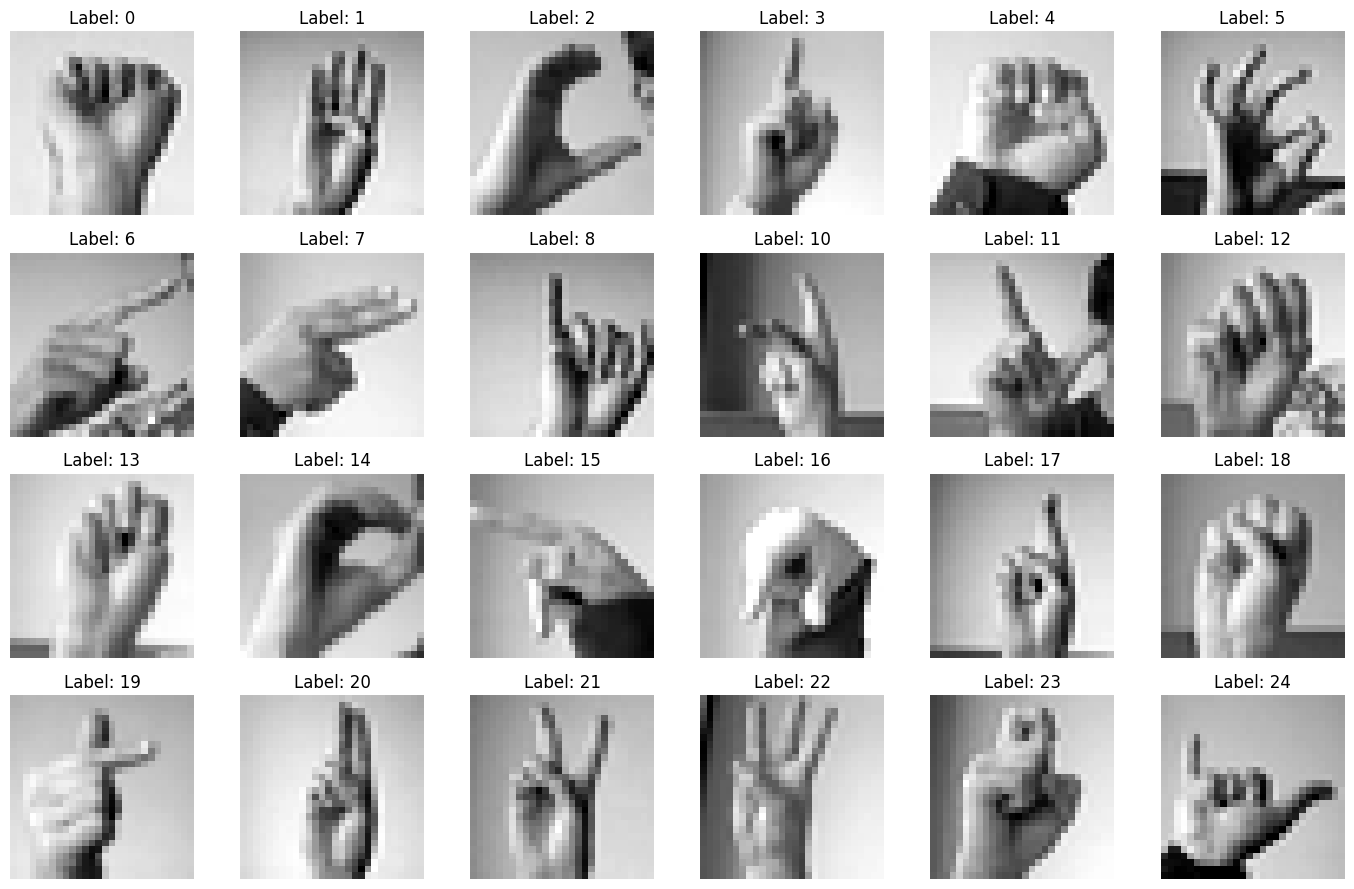

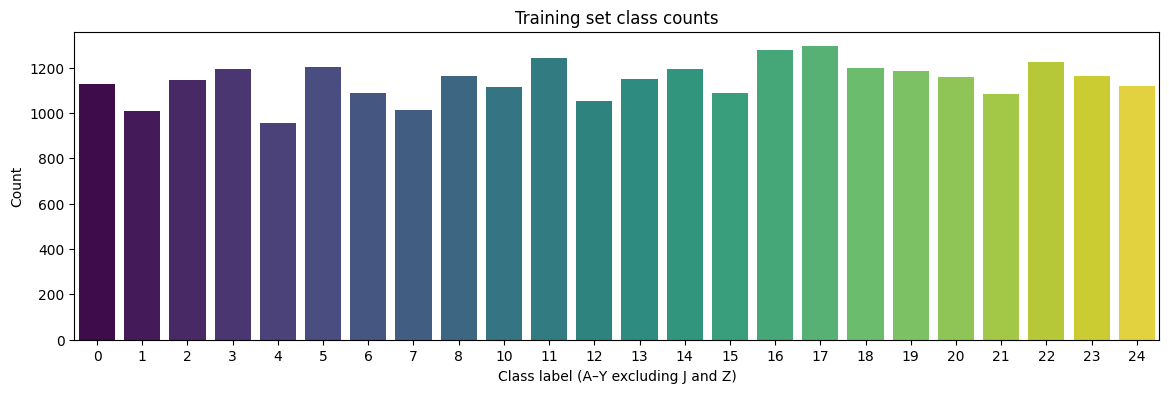

In [ ]:
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape,  y_test.shape)
print("Pixel range:", X_train.min(), "to", X_train.max())

# Show a grid of one image per class (24 classes, skipping label 9)
n = 24
cols = 6
rows = 4
plt.figure(figsize=(14, 9))
    # Find one index for each class, skipping label 9 (J)
unique_labels = [i for i in range(25) if i != 9]
for i, label in enumerate(unique_labels):
    idx = np.where(y_train == label)[0][0]
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Plot class distribution in the training set
labels_series = pd.Series(y_train)
plt.figure(figsize=(14,4))
sns.countplot(x=labels_series, hue=labels_series, palette='viridis', legend=False)
plt.title('Training set class counts')
plt.xlabel('Class label (A–Y excluding J and Z)')
plt.ylabel('Count')
plt.show()


### Comments
- Dimensions look correct, in training we have 27455 samples with each sample having (28x28=) 784 features
- Pixel values normalized to [0,1]
- Image grid shows one example of every class
- From the bar plot we see the data set appears to be relatively balanced, good for training.

# Task 2: Design your own ANN architecture
In this task you are free to design the network architecture for the MNIST Gesture recognition challenge with a couple of stipulations:
* use **only Dense or fully connected layers**,
* use both **accuracy and the F1-score** as performance metrics.

Otherwise, you are free to use whatever loss-function, optimizer and activation functions you want and train it for as many epochs you want.

## Task 2.1: Implement your own network architecture
Design your network below:

(Feel free to add as many code and markdown cells as you want)

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(25, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,673 (2.06 MB)

 Trainable params: 539,673 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

|

## Task 2.2: Train your network and visualize the training history
Train the model and plot the training history in the code cell(s) below. Feel free to use the function `plot_training_history()` and the custom Keras callback `F1ScoreCallback()` from Supporting code section.

In [ ]:
# Compile the model
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Validation set to tune hyperparameters
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

f1_callback = F1ScoreCallback(X_tr, y_tr, X_val, y_val)
# Train
history = model.fit(X_tr, y_tr,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[f1_callback])

Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2297 - loss: 2.5651 — f1: 0.4628 — val_f1: 0.4519
773/773 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2298 - loss: 2.5645 - val_accuracy: 0.4803 - val_loss: 1.5829 - f1: 0.4628 - val_f1: 0.4519
Epoch 2/10
768/773 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5905 - loss: 1.2399 — f1: 0.5821 — val_f1: 0.5751
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5909 - loss: 1.2388 - val_accuracy: 0.5885 - val_loss: 1.3538 - f1: 0.5821 - val_f1: 0.5751
Epoch 3/10
769/773 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7364 - loss: 0.7862 — f1: 0.6287 — val_f1: 0.6161
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7366 - loss: 0.7857 - val_accuracy: 0.6191 - val_loss: 1.2947 - f1: 0.6287 - val_f1: 0.6161
Epoch 4/10
772/773 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8238 - loss: 0.5316 — f1: 0.7238 — val_f1: 0.7105
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8238 - loss: 0.5315 - val_accuracy: 0.71

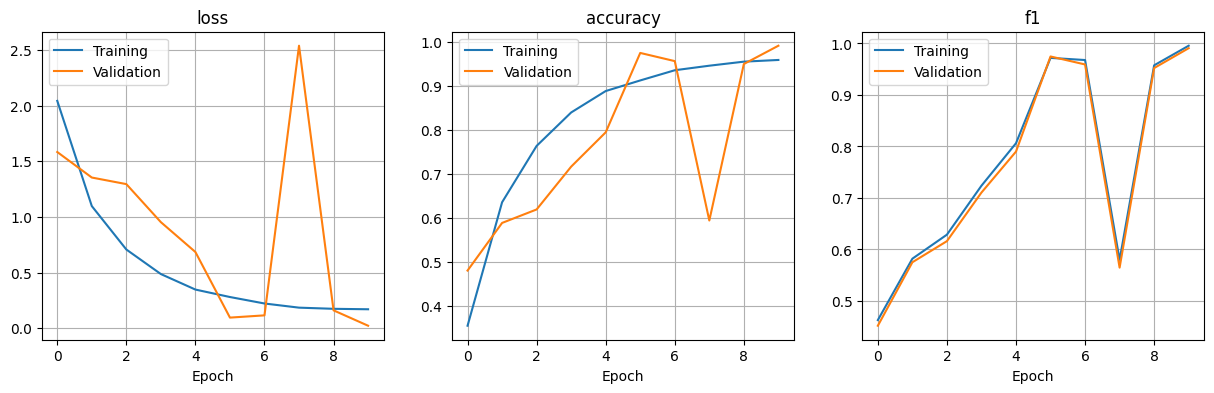

In [ ]:
plot_training_history(history, list_of_metrics=['loss', 'accuracy', 'f1'])

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Test Accuracy: {accuracy}')
print(f'Test F1-score: {f1:.4f}')

Test Accuracy: 0.8282208442687988
Test F1-score: 0.8108


## Task 2.3: Discuss the results
**Question 2.3.1**: What could happen if the model is too shallow or too deep?
    
    Too shallow:
    Too few layers might not have enough complexity, leading to underfitting.

    Too deep:
    Too many layers might lead to overfitting, and long training time from vanishing gradient.

**Question 2.3.2**: How does the choice of train/validation/test split ratio affect the training process and the final performance of a deep learning model?
    
    Need large enough training set to learn well, and not underfit.
    Validation set needs to be large enough for hyperparameter tuning and detecting overfitting.
    Test set needs to be large enough for final performance estimate on unseen data.

**Question 2.3.3**: How do accuracy and F1-Score values compare (are they similar or very different from each other)? What does it tell you about the MNIST dataset and which one of these metrics is more reliable in this case?

    F1 score and accuracy are very similar. Tells us that the dataset is balanced across classes. Both reliable here, but F1 would reveal poor performance if one class was rarer that the others.


**Question 2.3.4**: Explain **very briefly** how each of the following model hyperparameters can impact the model's performance:
```
- Number of layers
    Depth of network, more layers for more complex patterns, can lead to overfitting with too many or underfitting with too few.
- Number of neurons in a layer
    Width of network, increases computational cost and risk of overfitting. Too few might not allow the model to learn correctly.
- Batch size
    Number of samples process before weights are updated. Large for faster training but might converge to a less optimal solution. Small can lead to more noise but find a better minimum.
- Optimizers
    Algorithm used to update weights to minimize loss. Impact both training speed and final performance.
- Regularization techniques (such as L2 regularization).
    Used to prevent overfitting by adding penalty to the loss function. Eg, L2 penalizes large weights so the model uses more of all features rathern than just a few, for more generalization
```

# Task 3: Design and train a classical machine learning classifier
Pick your **favourite** machine learning classifer that you learned about in DAT200 and train it for the MNIST gesture recognition problem. (Hint: use the scikit-learn library). Remember to use **accuracy and the F1-score** as performance metrics.

In [ ]:
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Using X_train, y_train  X_test, y_test from before
# Scaling as in DAT200
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = RandomForestClassifier(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=42)

classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Random Forest Accuracy: {accuracy}')
print(f'Random Forest F1-score: {f1:.4f}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.3s


Random Forest Accuracy: 0.8169269380925822
Random Forest F1-score: 0.7995


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


# Task 4: Compare and discuss
Evaluate the ANN model you implemented in Task 2 against the classical machine learning model from Task 3, using the test dataset. Compare the two models based on:

* Accuracies and F1-scores they attain
* Time it takes to train them

Did you experience any trouble when training models in tasks 2 and 3?

>
For the ANN
Test Accuracy: 82.82%
Test F1-score: 0.8108

For the random forest
Random Forest Accuracy: 81.69%
Random Forest F1-score: 0.7995

Their scores and accuracies are very similar.

On google colab we saw similar training times ANN 42s vs Classifier 49s.
On our own pc the ANN trained in 18s and the classifier in 4.4s.
Classifier was much faster  there.


Did have trouble with what we saw as overfitting in the ANN, but regularization and dropout made the model perform bad. Train and Validation sets ≃ 95 accuracy, Test set only 76% accuracy.
Spikes in loss, accuracy, f1

For task 3 we took the simplest approach and saw no problems
